In [27]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten

import requests
from io import BytesIO
from PIL import Image, ImageFilter

import os

# Feed the images to the notebook

In [15]:
vgg_16 = VGG16()
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Base Model

In [3]:
class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

    


In [ ]:
def dataset_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle):
    
    with open(labels_file_path, 'r') as f:
        classes = f.read().split('\n')[:-1]
        
    images = []
    labels = []
    image_paths = []
    
    for image_name in os.listdir(dataset_path):
        try:
            image_path = os.path.join(dataset_path , image_name)
            images.append(image_loader(image_path, image_size))
            image_paths.append(image_path)
            
            for idx in range(len(classes)):
                if classes[idx] in image_name:
                    labels.append(idx)
        except:
            pass
        
    with open(image_paths_pickle + '.pickle', 'wb') as f:
        pickle.dump(image_paths, f)
        
    assert len(images) == len(labels)
    return np.array(images), np.array(labels)    

In [10]:
image_paths = []
    
for image_name in os.listdir("/Users/bahar/Desktop/test"):
    if '.png' in image_name:
        try:
            image_path = os.path.join("/Users/bahar/Desktop/test" , image_name)
            image_paths.append(image_path)

            for idx in range(len(classes)):
                if classes[idx] in image_name:
                    labels.append(idx)
        except:
            pass

In [11]:
image_paths

['/Users/bahar/Desktop/test/AHST3587.png',
 '/Users/bahar/Desktop/test/AJHS2870.png',
 '/Users/bahar/Desktop/test/AJHO1177.png',
 '/Users/bahar/Desktop/test/AHSU0114.png',
 '/Users/bahar/Desktop/test/ACOT1274.png',
 '/Users/bahar/Desktop/test/AJHS2865.png',
 '/Users/bahar/Desktop/test/ADNF1090.png',
 '/Users/bahar/Desktop/test/AHST3579.png',
 '/Users/bahar/Desktop/test/ALCT2835.png',
 '/Users/bahar/Desktop/test/AGNI1619.png',
 '/Users/bahar/Desktop/test/AGTG3902.png',
 '/Users/bahar/Desktop/test/AJHS3006.png',
 '/Users/bahar/Desktop/test/AJHO1174.png',
 '/Users/bahar/Desktop/test/AJHS1016.png',
 '/Users/bahar/Desktop/test/AGNI1620.png',
 '/Users/bahar/Desktop/test/ACOT3855.png',
 '/Users/bahar/Desktop/test/ADNF1109.png',
 '/Users/bahar/Desktop/test/ACOT1273.png',
 '/Users/bahar/Desktop/test/AGGR3637.png',
 '/Users/bahar/Desktop/test/AHST3580.png',
 '/Users/bahar/Desktop/test/AGNI1621.png',
 '/Users/bahar/Desktop/test/ACOT7760.png',
 '/Users/bahar/Desktop/test/AHFT1999.png',
 '/Users/ba

In [18]:
fe =  FeatureExtractor()   
# Iterate through images (Change the path based on your image location)

array_lst = []
for img_path in image_paths:
    print(img_path)
    # Extract Features
    feature = fe.extract(img=Image.open(img_path))
    array_lst.append(feature)
    print(feature, len(feature))
    # Save the Numpy array (.npy) on designated path
    #feature_path = "/Users/bahar/Desktop/test/feat/.npy"
    #np.save(feature_path, feature)
    
np.save('/Users/bahar/Desktop/test/feat/fnumpy.npy', array_lst)

/Users/bahar/Desktop/test/AHST3587.png
[0.         0.         0.00026459 ... 0.         0.         0.03103082] 4096
/Users/bahar/Desktop/test/AJHS2870.png
[0.         0.04800366 0.06556257 ... 0.         0.         0.04232574] 4096
/Users/bahar/Desktop/test/AJHO1177.png
[0.         0.01847    0.00527061 ... 0.         0.02293773 0.        ] 4096
/Users/bahar/Desktop/test/AHSU0114.png
[0.         0.01979999 0.00683617 ... 0.         0.         0.04966342] 4096
/Users/bahar/Desktop/test/ACOT1274.png
[0.         0.02844549 0.02687089 ... 0.         0.00645541 0.03125986] 4096
/Users/bahar/Desktop/test/AJHS2865.png
[0.         0.         0.02549106 ... 0.         0.         0.00788715] 4096
/Users/bahar/Desktop/test/ADNF1090.png
[0.00381077 0.00105519 0.05921277 ... 0.         0.         0.        ] 4096
/Users/bahar/Desktop/test/AHST3579.png
[0.00405816 0.0146881  0.03996784 ... 0.         0.         0.01320553] 4096
/Users/bahar/Desktop/test/ALCT2835.png
[0. 0. 0. ... 0. 0. 0.] 4096
/Use

[0.02998281 0.         0.0519481  ... 0.         0.         0.00690903] 4096
/Users/bahar/Desktop/test/ABFR1580.png
[0.00504989 0.         0.07967915 ... 0.         0.00053244 0.        ] 4096
/Users/bahar/Desktop/test/AGRV4836.png
[0.         0.         0.05570757 ... 0.         0.00628356 0.04779943] 4096
/Users/bahar/Desktop/test/AHST2907.png
[0.03987078 0.         0.01490462 ... 0.         0.         0.        ] 4096
/Users/bahar/Desktop/test/AJHS1393.png
[0.02620506 0.         0.01146938 ... 0.         0.         0.00140919] 4096
/Users/bahar/Desktop/test/ALCT2635.png
[0. 0. 0. ... 0. 0. 0.] 4096
/Users/bahar/Desktop/test/ABFR1434.png
[0.01135605 0.         0.05414153 ... 0.         0.         0.        ] 4096
/Users/bahar/Desktop/test/AEIT1018.png
[0.02374017 0.         0.01559985 ... 0.         0.         0.00315144] 4096
/Users/bahar/Desktop/test/ABFR1024.png
[0.00633129 0.         0.09494674 ... 0.         0.         0.03071539] 4096
/Users/bahar/Desktop/test/AGTG3892.png
[0.0

In [19]:
array_reloaded = np.load('/Users/bahar/Desktop/test/feat/fnumpy.npy')

In [20]:
array_reloaded

array([[0.        , 0.        , 0.00026459, ..., 0.        , 0.        ,
        0.03103082],
       [0.        , 0.04800366, 0.06556257, ..., 0.        , 0.        ,
        0.04232574],
       [0.        , 0.01847   , 0.00527061, ..., 0.        , 0.02293773,
        0.        ],
       ...,
       [0.        , 0.        , 0.04355727, ..., 0.        , 0.00086355,
        0.        ],
       [0.        , 0.01914313, 0.01547263, ..., 0.        , 0.        ,
        0.        ],
       [0.03394508, 0.        , 0.03932517, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

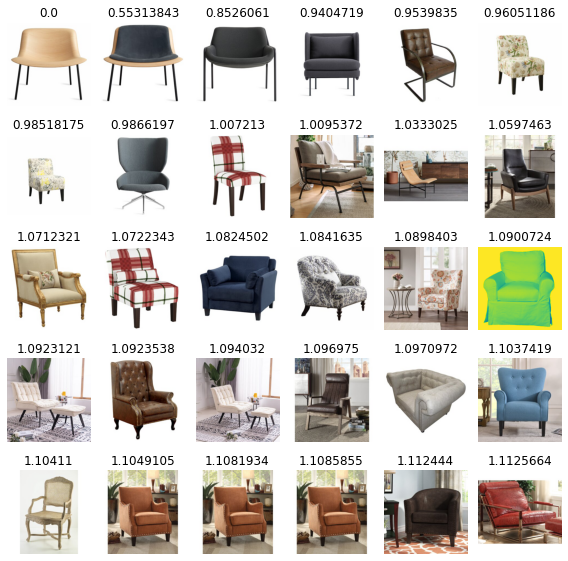

In [25]:
# Insert the image query
img = Image.open("/Users/bahar/Desktop/test/ABFR1130.png")
# Extract its features
query = fe.extract(img)
# Calculate the similarity (distance) between images
dists = np.linalg.norm(array_reloaded - query, axis=1)
# Extract 30 images that have lowest distance
ids = np.argsort(dists)[:30]
scores = [(dists[id], image_paths[id]) for id in ids]
# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(5*6):
    score = scores[a]
    axes.append(fig.add_subplot(5, 6, a+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

In [26]:
print(dists)

[1.2028983  1.2157665  1.1409442  1.1759762  1.1748374  1.1902376
 1.126032   1.1237521  1.2565273  1.1037419  1.007213   1.1492928
 1.1643869  1.0824502  1.2506363  1.1453704  1.1843868  1.1962764
 1.1769555  1.1085855  1.1470293  1.1591192  1.1998152  1.1049105
 1.2077047  1.2256889  1.1660668  1.1555471  1.1770936  1.1785076
 1.0712321  1.2518575  1.127667   1.1588346  1.10411    1.1138448
 1.0095372  1.1939472  1.1219281  0.96051186 1.1336986  1.1939449
 1.0970972  1.0597463  1.2582209  1.096975   1.1897292  1.0923121
 1.2278669  0.         1.1154008  1.2189012  1.1865355  1.1125664
 1.1599025  1.2637429  1.1081934  1.1519626  0.98518175 1.1528317
 1.2179885  1.112444   1.1491219  1.2391557  1.1384281  1.1587274
 1.2330899  1.0923538  0.9866197  1.1246284  1.2435011  1.0333025
 0.9539835  0.8526061  1.0900724  1.0841635  1.120454   1.1897769
 0.55313843 1.1220233  0.9404719  1.0722343  1.0898403  1.094032
 1.2092506 ]


In [ ]:
### COSINE SIMILARITY #####

# Insert the image query
img = Image.open("/Users/bahar/Desktop/test/ABFR1130.png")
# Extract its features
query = fe.extract(img)
# Calculate the similarity (distance) between images
dists = np.linalg.norm(array_reloaded - query, axis=1)
# Extract 30 images that have lowest distance
ids = np.argsort(dists)[:30]
scores = [(dists[id], image_paths[id]) for id in ids]
# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))
for a in range(5*6):
    score = scores[a]
    axes.append(fig.add_subplot(5, 6, a+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()